In [29]:
%matplotlib inline
import sys
import os
import os.path
import subprocess
import numpy as np

import tables as tb
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from astropy.visualization import ZScaleInterval
from astropy.table import Table, vstack, Column
from astropy.io import ascii

from datetime import datetime

import glob

# build Master Table

In [50]:
# now load survey file, such that we can select shot that fullfill certain criteria, such as expsure time etc.
import sys
sys.path.append('/home1/04287/mxhf/HETDEX_API/')

from hetdex_api.survey import Survey
survey = Survey('hdr1')
thdr1 = Table(survey.hdfile.root.Survey[:])

uhdr1shotids  = np.unique( thdr1["datevobs"] )

In [51]:
# make sure the images database is complete
for s in uhdr1shotids[:1714]:
    ff = glob.glob("/work/04287/mxhf/maverick/hetdex/{}.images.txt".format(s))
    if ff == 0:
        print("No image information found for {}.".format(s))

In [52]:
# Old
if True:
    ff = glob.glob("/work/04287/mxhf/maverick/hetdex/20*.images.txt")
    tt = []
    for f in ff:
        h,t = os.path.split(f)
        shotid = t.replace("cubes","").replace(".images.txt","")
        t = ascii.read(f)
        date,shotnum = shotid.split("v")
        t.add_column(Column([shotid]*len(t)), 0, name="shotid")
        t.add_column(Column([int(date)]*len(t)), 1, name="date")
        t.add_column(Column([int(shotnum)]*len(t)), 2, name="shotnum")
        tt.append(t)

    tt = vstack(tt)

In [53]:
len(tt)

705574

In [5]:
# load hardware configuration form Erin (somehow getting stage results, falling back to our own)
if False:
    tt = ascii.read("hdr1_instrument_ids.tab")

In [6]:
# add unique hardware configuration identifier
hwids = []
for r in tt:
    hwids.append( "{}-{:03d}-{:03d}-{:03d}".format(r["contid"].format("", "-"),r["ifuid"], r["ifuslot"], r["specid"]))
tt.add_column(Column(hwids, name="hwids") )

In [7]:
# add date information
if not "intdate" in tt.colnames:
    tt.add_column(Column([int(shotid[:8]) for shotid in tt["shotid"]], name="intdate"), 1 )


In [8]:
if not "shotnum" in tt.colnames: 
    tt.add_column(Column([int(shotid[9:12]) for shotid in tt["shotid"]], name="shotnum"), 2 )

In [9]:
uhwids = np.unique(hwids)

In [10]:
# add minimum exposure time
if "minexptime" in tt.colnames:
    tt.remove_column("minexptime")
tt.add_column(Column([-1.]*len(tt),name="minexptime"))


for shotid in uhdr1shotids:
    minexptime = np.array([ thdr1["exptime"][thdr1["datevobs"] == shotid] ]).min()
    tt["minexptime"][tt["shotid"] == shotid] = minexptime

In [11]:
tt.write("/work/04287/mxhf/maverick/hetdex/hwconfig_mastertable.txt", format="ascii.ecsv")

# Now select shots to use

In [30]:
tt = ascii.read("/work/04287/mxhf/maverick/hetdex/hwconfig_mastertable.txt", format="ecsv")

In [31]:
if "date" in tt.colnames:
    tt.remove_column("date")
tt.add_column(Column([datetime.strptime(shotid[:8], "%Y%m%d") for shotid in tt["shotid"]], name="date"), 1 )

In [32]:
# only use data from >= 2018
ii  = tt["intdate"] >= 20180000
# hetdex-like exposure times
ii *= np.array(tt["minexptime"]) >= 360.
ii *= np.array(tt["minexptime"]) <= 500.
if "use" in tt.colnames:
    tt.remove_column("use")

tt.add_column(Column(ii,name="use"))

In [33]:
tt[ tt["use"] ]

<Table length=467922>
   shotid            date        intdate  ...     minexptime    use 
   str12            object        int64   ...      float64      bool
------------ ------------------- -------- ... ----------------- ----
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
20181107v011 2018-11-07 00:00:00 20181107 ... 427.0999755859375 True
         ...                 ...      ... ...               ...  ...
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True
20180310v002 2018-03-10 00:00:00 20180310 ... 367.4993591308594 True

In [40]:
ll = [ (r["shotid"] + "_{:03d}".format(r["ifuslot"])) for r in tt[ tt["use"] ] ]

In [36]:
ll = np.unique( list( zip( tt[ tt["use"] ]['shotid'], tt[ tt["use"] ]['ifuslot'] ) ) )

In [49]:
len(tt)

705574

In [48]:
len( np.unique( tt[tt["use"]]["shotid"]) ) * 50

51250

In [47]:
len( np.unique(ll) )

39538

In [18]:
print("Using {} out of {}".format(np.sum( ii ),len(tt) ))

Using 467922 out of 705574


In [19]:
tt[( tt["intdate"] == 20180618) * (tt["shotnum"] == 17 ) ]

<Table length=468>
   shotid            date        intdate  ...     minexptime    use 
   str12            object        int64   ...      float64      bool
------------ ------------------- -------- ... ----------------- ----
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
         ...                 ...      ... ...               ...  ...
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True
20180618v017 2018-06-18 00:00:00 20180618 ... 366.9017333984375 True

In [20]:
import matplotlib
dates = matplotlib.dates.date2num(tt["date"])

Text(0, 0.5, 'ifu slot')

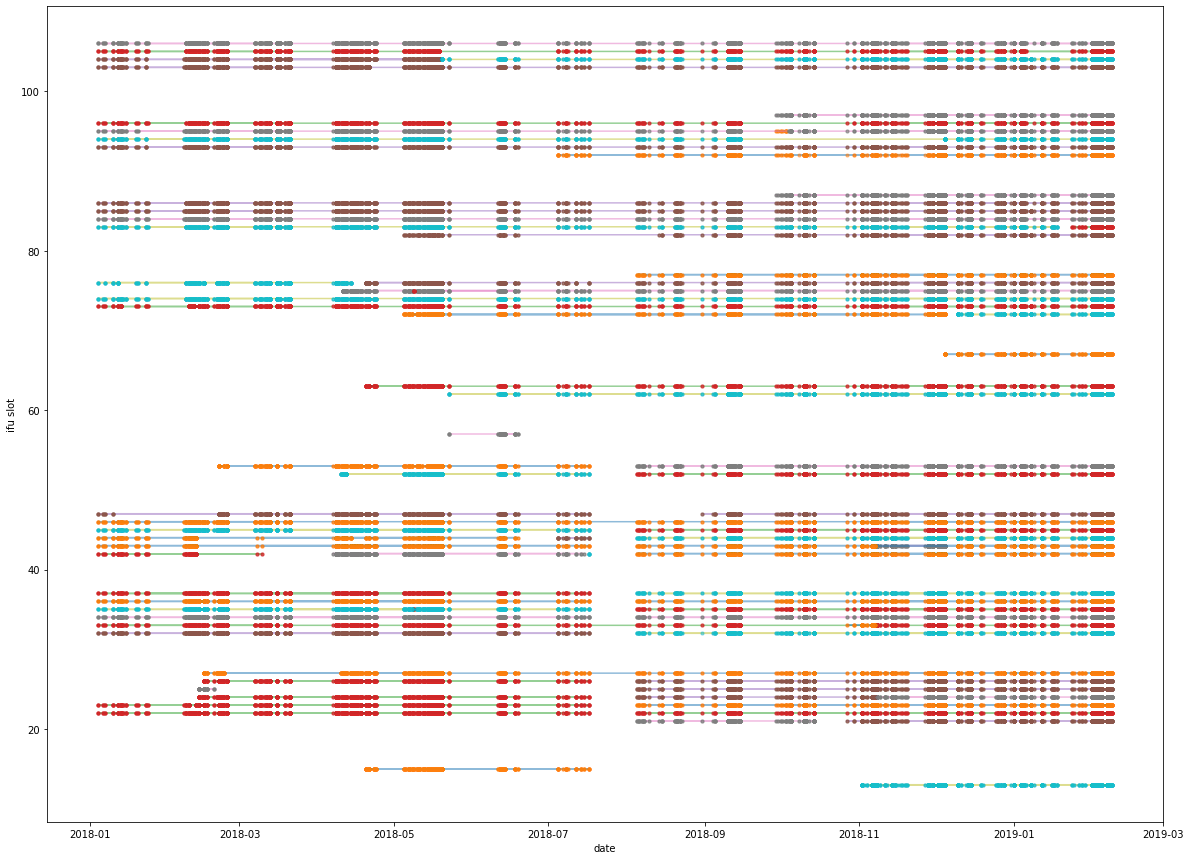

In [21]:
# plot
f = plt.figure(figsize=[20,15])
ax = plt.subplot(111)


for hwid in uhwids:
    ii = tt["hwids"] == hwid
    #plt.plot(tt["date"][ii], tt["ifuslot"][ii])
    #plt.plot(tt["date"][ii]*1000 + tt["shotnum"][ii], tt["ifuslot"][ii], alpha=.1)
    #plt.plot(tt["date"][ii * tt["use"]]*1000 + tt["shotnum"][ii* tt["use"]], tt["ifuslot"][ii* tt["use"]], alpha=.1, marker='.')
    plt.plot_date(dates[ii * tt["use"]], tt["ifuslot"][ii* tt["use"]],'-', alpha=.5 )
    plt.plot_date(dates[ii * tt["use"]], tt["ifuslot"][ii* tt["use"]], alpha=.1, marker='.')
    
plt.xlabel("date")
plt.ylabel("ifu slot")
#ax.set_xticklabels(ax.get_xticklabels(), rotation = 45)



#matplotlib.pyplot.plot_date(dates, values)

In [22]:
tt.sort(["intdate","shotnum"])

In [23]:
#r["contid"].format("", "-"),r["ifuid"], r["ifuslot"], r["specid"]
np.unique( tt[(tt["ifuslot"] == 42) * tt["use"]]["hwids"] )

<Column name='hwids' dtype='str20' length=4>
S/N 0077-030-042-321
S/N 0089-073-042-315
S/N 0097-073-042-315
S/N 0107-073-042-315

In [24]:
def get_hwconfig(shotid, ifuslot):
    # for a shot and a ifuslot find the hawrdware configuration (= hwid)
    jj = tt["shotid"] == shotid
    jj *= tt["ifuslot"] == ifuslot
    
    uhwids = np.unique(tt[jj]["hwids"])
    if not len(uhwids) == 1:
        print("Error could not uniquely identify hardware configuration.")
        return
    return uhwids[0]

def get_shots_for_hwconfig(hwid):
    # now find *all* shots that had that hwardware configuration
    jj = tt["hwids"] == hwid
    shotids = np.unique( tt["shotid"][jj] )
    return Table([shotids])

hwid  = get_hwconfig("20181102v011", 13) 
shotids = get_shots_for_hwconfig(hwid)

In [25]:
ushotids = np.unique(tt["shotid"][tt["use"]])
for shotid in ushotids:
    jj = tt["shotid"] == shotid
    uifuslots = np.unique(tt["ifuslot"][jj])
    for ifuslot in uifuslots:
        hwid  = get_hwconfig(shotid, ifuslot) 
        shotids = get_shots_for_hwconfig(hwid)
        outfilename = "/work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_{}_ifu{:03d}.txt".format(shotid, ifuslot)
        shotids.write(outfilename, format='ascii.no_header')
        print("Wrote {}".format(outfilename))
        
        outfilename = "/work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_{}_ifu{:03d}.txt".format(shotid, ifuslot)
        with open(outfilename, 'w') as f:
            f.write(shotid)
        #np.savetxt("/work/04287/mxhf/maverick/hetdex/cubes/shotlist_PCA_{}_{}.txt".format(shotid, ifuslot), shotids, encoding='latin1')

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180104v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180106v005

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180110v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180112v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v010_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180113v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180114v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180115v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180120v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v010_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v010_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v010_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180123v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v008_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v008_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180207v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180208v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180209v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v006

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v014_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180210v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180211v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180212v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180213v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180214v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v005_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v006_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v006_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v006_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v006

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180215v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180216v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180220v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180221v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v017_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v017_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180222v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180223v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v005

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180224v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v002_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v002_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v002_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v002_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v002_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v003

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v006_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180307v006_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180308v002

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v002_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v002_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v003

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180309v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180310v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180311v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180312v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v015_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v015_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v015_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180313v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180316v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180317v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180319v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180320v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v010_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v010_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180321v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180407v002

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v004

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180408v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180411v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v020_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180412v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v005

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180414v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v010_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v010_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180415v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v010_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v010_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v010_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180416v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v019_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180417v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180418v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180419v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180420v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v009_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v014_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180421v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180423v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180424v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180505v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180506v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180507v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180508v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180509v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v007_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v009_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180510v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180511v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v010_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v010_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v010_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180512v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180513v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v002

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180514v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v005

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180515v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180516v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v006_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v006_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v006_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v006_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180517v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v008_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v009_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180518v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180519v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180520v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180523v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu057.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180611v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v017_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v017_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu057.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180612v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v016_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu057.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180613v024_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v013_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v013_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu057.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180614v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v019_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180618v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180619v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180705v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v004_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v004_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v004_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v004_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v004_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v005

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180708v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180709v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v015_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180712v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180714v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180715v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v012_ifu015.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180717v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180805v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180806v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180807v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v025_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v026_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v026_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v026_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180808v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180814v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180815v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180820v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v023_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v028_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v028_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180821v028_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180822v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180823v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180904v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180905v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v020_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v021_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v021_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v022_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v022_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180910v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180911v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v020_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v020_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v021_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v021_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v021_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v021_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180912v028

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180913v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180914v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v017_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v018_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v018_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180915v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20180929v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181001v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181002v006

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181003v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v007_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181004v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v007_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v007_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181005v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181008v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v025_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v025_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v025_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v027_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181010v029

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181011v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v010_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v010_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v010_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v010_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181014v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181030v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181102v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181104v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181106v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181107v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181108v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181109v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181111v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181114v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181115v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181116v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181118v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181119v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181120v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181127v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v009_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181128v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v007_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v011_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v012_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181129v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v011_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v011_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v013_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v013_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v015_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v015_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v017_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v018_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v018_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v020_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v020_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181130v021_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v013_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v013_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v015_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v015_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v017_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v017_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v019_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v019_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v020_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v021_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v021_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v021_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v023_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v023_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v023_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v023_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181202v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v012_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v012_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v020_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v020_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v022_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181203v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v017_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v019_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v021_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v023_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v028_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v029

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181204v030_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v012_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v012_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v012_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v015_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v015_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181205v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181210v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181211v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181213v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v013_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v013_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v013_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v016_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v016_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181214v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v029

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v031

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v033

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181215v035

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v006

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181219v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181225v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181226v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v003_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v003_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v003_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v004

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v005_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v006_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v006_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v006_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v006_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v006

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181227v007_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181228v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20181231v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190101v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v009

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v010_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v010_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v016_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v019_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190104v026

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v026_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v026_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v026_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v026_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v028_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v029_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v029_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v029_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v029

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v030_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190105v031

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190106v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v002_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v003_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v003_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v003

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v018_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190108v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190109v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v029

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v031

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190112v033

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190116v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v020_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v022_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v022_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190117v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v014_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v014_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v014_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v014_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v016_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v016_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190118v016_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190124v023_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190125v010_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190125v010

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190127v008

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v007

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190128v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190129v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v013

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v017

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190201v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v011

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v012_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v015_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v015_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v015_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v015_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v015_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v017_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v018_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v018_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190202v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v020

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190203v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v012

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v014

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190204v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v016

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v018_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v018_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v018_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v018_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v019

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v022_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v023_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v023_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190205v024

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v015

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v018

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu076.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu072.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu073.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu074.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023_ifu075.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu053.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu062.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu063.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025_ifu067.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190207v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu045.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu046.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu047.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021_ifu052.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu037.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu042.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu043.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023_ifu044.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v023

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu033.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu034.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu035.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025_ifu036.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v025

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v026_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu025.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu026.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu027.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027_ifu032.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v027

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v028_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v028_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v028_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v028_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v028_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035_ifu021.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035_ifu022.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035_ifu023.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035_ifu024.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190208v035

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu104.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu105.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v020_ifu106.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v021_ifu013.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v021

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu095.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu096.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu097.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022_ifu103.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v022

Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu077.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu082.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu083.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu084.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu085.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu086.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu087.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu092.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu093.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025_ifu094.txt
Wrote /work/04287/mxhf/maverick/hetdex/cubes/shotlists/shotlist_PCA_20190209v025

In [ ]:
#!mv  /work/04287/mxhf/maverick/hetdex/cubes/shotlists /work/04287/mxhf/maverick/hetdex/cubes/shotlists_old